# Dados do Case

### Contexto:

<p>O projeto visa a classificação automática de imagens digitais para distinguir entre duas classes distintas: cães e gatos. O desafio central consistiu em realizar essa tarefa de Visão Computacional sem a utilização de Redes Neurais Profundas (Deep Learning/CNNs), optando por técnicas de Machine Learning clássico ("Shallow Learning"). O objetivo foi criar um pipeline robusto de engenharia de características capaz de identificar padrões visuais complexos (como textura de pelos e formatos de orelhas/focinhos) transformando dados não estruturados (pixels) em vetores matemáticos interpretáveis por algoritmos tradicionais.</p>

### Solução desenvolvida:

* Foi implementado um fluxo completo de Engenharia de Recursos (Feature Engineering) e Classificação:
* **Pré-processamento de Imagem:** Padronização das entradas com redimensionamento ( pixels), conversão para escala de cinza e aplicação de Gaussian Blur para redução de ruído.
* **Extração de Características (Feature Engineering):**
* **Filtros de Sobel:** Aplicação de gradientes nas direções X e Y para detecção de bordas e contornos, gerando a magnitude das arestas.
* **Descritores de Forma:** Cálculo dos Momentos de Hu (invariantes à rotação e escala) sobre a imagem de bordas.
* **Estatística:** Extração da média e desvio padrão da magnitude do gradiente para capturar a densidade da textura.
* **Pipeline de Machine Learning:** Normalização dos dados via `StandardScaler` e classificação utilizando SVM (Support Vector Machine) com kernel RBF, otimizado via `GridSearchCV`.

### Ferramentas utilizadas:
* **Linguagem:** Python 3.
* **Bibliotecas de Processamento:** OpenCV (`cv2`) para manipulação de imagem e filtros; Numpy para álgebra linear.
* **Base de dados:** Foi utilizado uma base com 15k de imagens de gatos e cães.
* **Machine Learning:** Scikit-learn (`sklearn`) para implementação do classificador SVM, `Pipeline`, `StandardScaler` e codificação de labels (`LabelEncoder`).
* **Validação e Métricas:** Otimização de hiperparâmetros com `GridSearchCV`, validação cruzada (K-Fold=5) e avaliação via Matriz de Confusão, Curva ROC-AUC, Kappa de Cohen e MCC.

### Resultados alcançados:

* **Pipeline Funcional:** Desenvolvimento de um sistema ponta a ponta capaz de ingerir imagens cruas e emitir predições probabilísticas.
* **Robustez na Avaliação:** Implementação de métricas avançadas (além da acurácia simples) que garantem que o modelo distingue efetivamente as classes e não apenas "chuta" a classe majoritária, validado por curvas ROC e análise de sensibilidade.
* **Acuracia:** Foi alcançado uma acurácia de 68% para 4k amostras de imagens

## Bloco 1: Instalação de Dependências
Execute o comando:
- Criar ambiente virtual e ativa-lo:
```shell
    python3 -m venv .venv
    source .venv/bin/activate
```
- instalar dependências:
```shell
    pip3 install -r requirements.txt
```
- faça o download do dataset em [link para download](https://www.kaggle.com/datasets/bhavikjikadara/dog-and-cat-classification-dataset?resource=download)
- coloque em: <br>
 ./datasets/PetImages/Cat <br>
 ./datasets/PetImages/Dog

In [1]:
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

IMG_SIZE = 64
numbers_sample=2000 #entre 500 a 12500

## 2. Extração de Features com Filtro de Sobel

- Sobel X e Y: Calcula a derivada da intensidade (onde a cor muda bruscamente).

- Magnitude: Junta X e Y para criar uma imagem onde pixels brancos = bordas fortes.

- Features Estatísticas: A média e desvio padrão da magnitude dizem o quão "texturizada" ou "complexa" é a imagem.

In [2]:
def extrair_features_sobel(caminho_imagem):
    try:
        # 1. Ler em Cinza
        img = cv2.imread(caminho_imagem, cv2.IMREAD_GRAYSCALE)
        if img is None: return None
        
        # 2. Redimensionar e aplicar Blur (reduz ruído antes do Sobel)
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img_blur = cv2.GaussianBlur(img_resized, (3, 3), 0)
        
        # 3. Aplicar Sobel
        # cv2.CV_64F permite valores negativos (derivadas negativas), essencial para o cálculo correto
        sobelx = cv2.Sobel(img_blur, cv2.CV_64F, 1, 0, ksize=3) # Derivada em X
        sobely = cv2.Sobel(img_blur, cv2.CV_64F, 0, 1, ksize=3) # Derivada em Y
        
        # 4. Calcular Magnitude (Força das bordas)
        magnitude = cv2.magnitude(sobelx, sobely)
        
        # --- FEATURE SET 1: Estatísticas das Bordas ---
        # Cães e gatos podem ter densidades de bordas diferentes devido à pelagem
        mean_edge = np.mean(magnitude)
        std_edge = np.std(magnitude)
        
        # --- FEATURE SET 2: Momentos de Hu na Magnitude ---
        # Tratamos a imagem de bordas como uma "forma" para calcular geometria
        # Normalizamos a magnitude para 0-255 para calcular momentos
        mag_norm = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        moments = cv2.moments(mag_norm)
        hu_moments = cv2.HuMoments(moments).flatten()
        
        # Log transform para estabilizar os Hu Moments (evitar valores minúsculos)
        # Adicionamos 1e-10 para evitar log(0)
        hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
        
        # --- FEATURE SET 3: Raw Pixels da Magnitude (Achatados) ---
        # Usamos a própria imagem de bordas como feature visual
        raw_edges = magnitude.flatten()
        
        # Concatenar tudo: [Hu(7), Media(1), Std(1), Pixels(4096)]
        features = np.concatenate([hu_moments, [mean_edge, std_edge], raw_edges])
        
        return features

    except Exception as e:
        print(f"Erro em {caminho_imagem}: {e}")
        return None

# Teste visual rápido para ver o Sobel
print("Função de Sobel definida.")

Função de Sobel definida.


## 3. Processando o Dataset
Varre as pastas, aplica o Sobel e guarda os vetores numéricos.

In [3]:
import random
raw_data = []
labels = []
# 1. Carregar todos os caminhos
dogs_path = glob.glob('./datasets/PetImages/Dog/*.jpg')
cats_path = glob.glob('./datasets/PetImages/Cat/*.jpg')

# 2. Embaralhar as listas (O shuffle altera a variável original e não retorna nada)
random.shuffle(dogs_path)
random.shuffle(cats_path)

# 3. Criar o dicionário pegando os n primeiros de cada lista JÁ embaralhada
caminhos = {
    'dog': dogs_path[:numbers_sample], 
    'cat': cats_path[:numbers_sample],
}
print("Iniciando processamento com Sobel...")

for label_name, lista_arquivos in caminhos.items():
    print(f"Processando {label_name}: {len(lista_arquivos)} imagens encontradas.")
    
    for arquivo in lista_arquivos:
        feat = extrair_features_sobel(arquivo)
        if feat is not None:
            raw_data.append(feat)
            labels.append(label_name)

# Verificação de segurança para evitar o erro anterior
if len(raw_data) == 0:
    print("ERRO CRÍTICO: Nenhuma imagem processada. Verifique os caminhos no glob.")
else:
    print(f"Sucesso! {len(raw_data)} imagens transformadas em vetores de features.")

Iniciando processamento com Sobel...
Processando dog: 2000 imagens encontradas.


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


Processando cat: 2000 imagens encontradas.


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


Sucesso! 4000 imagens transformadas em vetores de features.


## 4. Treinamento SVM

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
import random

if len(raw_data) > 0:
    # 1. Converter listas para Arrays Numpy
    X = np.array(raw_data)
    y_labels = np.array(labels) # Estes são textos ('dog', 'cat')

    # 2. Codificar Labels (Texto -> Número)
    # Necessário para calcular AUC e ROC
    le = LabelEncoder()
    y = le.fit_transform(y_labels) # 0 e 1
    print(f"Classes detectadas: {le.classes_} -> transformadas em [0, 1]")

    # 3. Divisão Treino (80%) vs Validação/Teste (20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 4. Normalização (StandardScaler)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("Dados preparados e normalizados.")
else:
    print("ERRO: raw_data está vazio.")

Classes detectadas: ['cat' 'dog'] -> transformadas em [0, 1]
Dados preparados e normalizados.


In [5]:
print("Treinando modelo SVM com cálculo de probabilidade...")

# probability=True é obrigatório para desenhar a curva ROC depois
model = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
model.fit(X_train_scaled, y_train)

print("Modelo treinado!")

Treinando modelo SVM com cálculo de probabilidade...
Modelo treinado!



--- Resumo Executivo ---
Acurácia: 63.12%
Kappa de Cohen: 0.2628 (Quanto maior, melhor)
MCC (Matthews): 0.2633 (Quanto mais perto de 1, melhor)
Log Loss: 0.6445 (Quanto menor, melhor)

--- Relatório Detalhado ---
              precision    recall  f1-score   support

         cat       0.60      0.64      0.62       378
         dog       0.66      0.62      0.64       422

    accuracy                           0.63       800
   macro avg       0.63      0.63      0.63       800
weighted avg       0.63      0.63      0.63       800



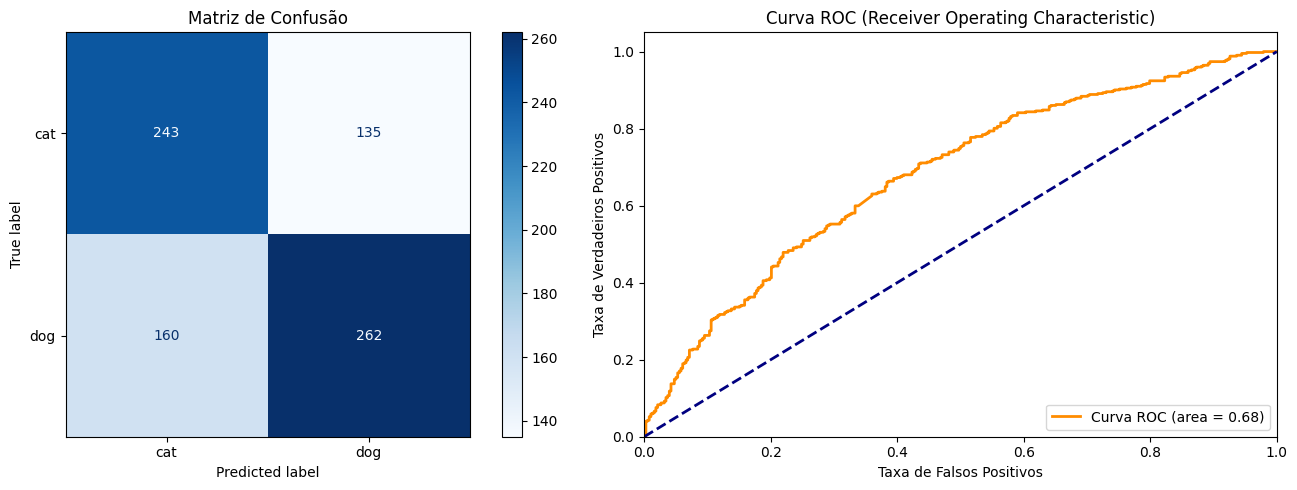

In [6]:
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, auc, 
                             cohen_kappa_score, matthews_corrcoef, log_loss)

# 1. Gerar Predições
y_pred = model.predict(X_test_scaled)           # Classe final (0 ou 1)
y_proba = model.predict_proba(X_test_scaled)[:, 1] # Probabilidade da classe positiva (ex: ser gato)

# 2. Métricas Básicas
acc = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
loss = log_loss(y_test, y_proba)

print(f"\n--- Resumo Executivo ---")
print(f"Acurácia: {acc*100:.2f}%")
print(f"Kappa de Cohen: {kappa:.4f} (Quanto maior, melhor)")
print(f"MCC (Matthews): {mcc:.4f} (Quanto mais perto de 1, melhor)")
print(f"Log Loss: {loss:.4f} (Quanto menor, melhor)")

print("\n--- Relatório Detalhado ---")
target_names = [str(c) for c in le.classes_]
print(classification_report(y_test, y_pred, target_names=target_names))

# --- PLOTS VISUAIS ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot A: Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues, ax=ax[0])
ax[0].set_title("Matriz de Confusão")

# Plot B: Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (area = {roc_auc:.2f})')
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('Taxa de Falsos Positivos')
ax[1].set_ylabel('Taxa de Verdadeiros Positivos')
ax[1].set_title('Curva ROC (Receiver Operating Characteristic)')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()